In [2]:
import pandas_datareader
from pandas_datareader import data
import pandas_datareader.data as pdr
from datetime import datetime

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## Bitcoin

In [3]:
#setting the end date to today
end = datetime.today()

#Start date set to 2019-09-17
start = '2019-09-17'

#using yahoo finance to grab data
BTC_df = pdr.DataReader('BTC-INR','yahoo',start,end)

In [4]:
BTC_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-01,3005829.50,2879661.50,2968276.0,2913965.25,1.902551e+12,2913965.25
2021-08-02,2955321.25,2804236.75,2912215.5,2831506.50,1.943667e+12,2831506.50
2021-08-03,2964554.00,2789774.00,2835985.5,2948865.25,1.882389e+12,2948865.25
2021-08-04,3063079.25,2777084.00,2948643.5,3027324.25,2.606255e+12,3027324.25
2021-08-06,3053737.00,2961425.50,3035650.0,3026077.00,2.696955e+12,3026077.00


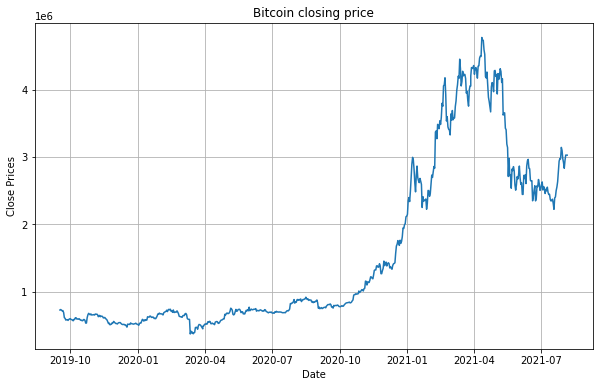

In [5]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(BTC_df['Close'])
plt.title('Bitcoin closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

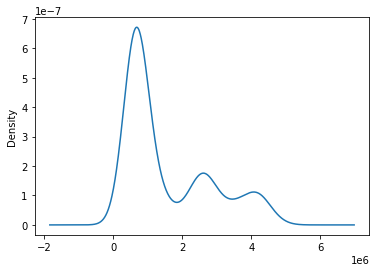

In [6]:
#Distribution of the dataset
df_close = BTC_df['Close']
df_close.plot(kind='kde')


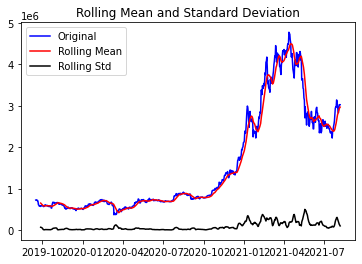

Results of dickey fuller test
Test Statistics                 -0.687629
p-value                          0.849928
No. of lags used                14.000000
Number of observations used    670.000000
critical value (1%)             -3.440148
critical value (5%)             -2.865863
critical value (10%)            -2.569072
dtype: float64


In [7]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(BTC_df[['Close']])

<Figure size 432x288 with 0 Axes>

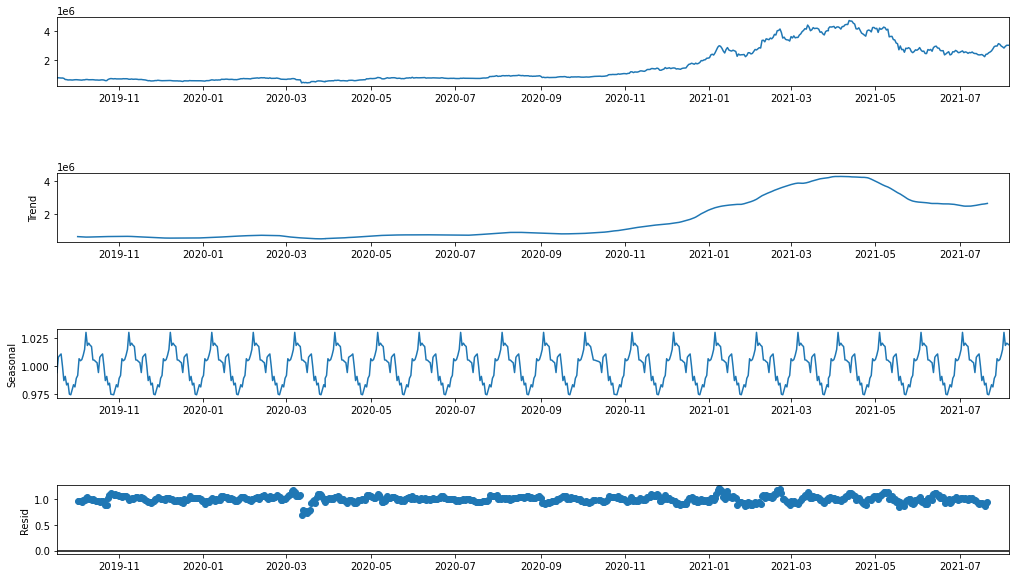

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(BTC_df[['Close']], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


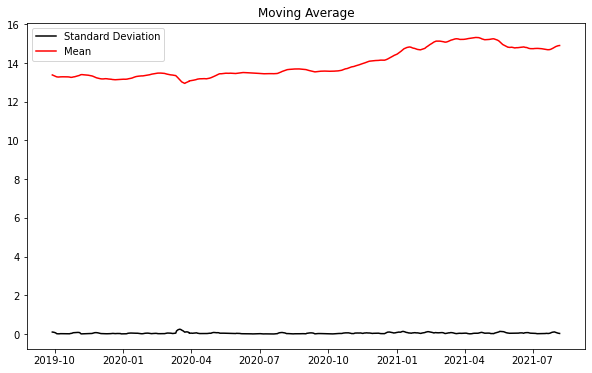

In [9]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(BTC_df[['Close']])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

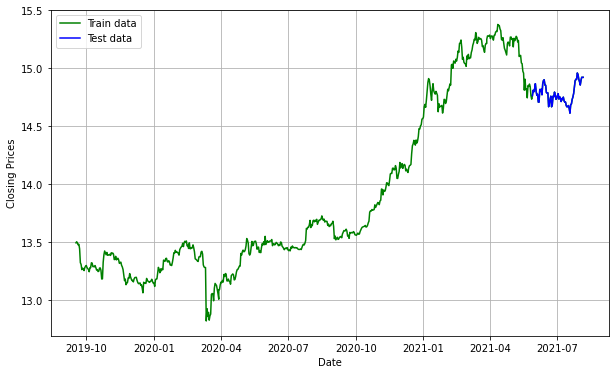

In [10]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2168.868, Time=1.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2170.403, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2169.885, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2169.336, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2172.983, Time=0.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2172.203, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2175.345, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2176.495, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2175.370, Time=0.99 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2171.655, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2173.599, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2176.929, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2170.123, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2170.619, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0

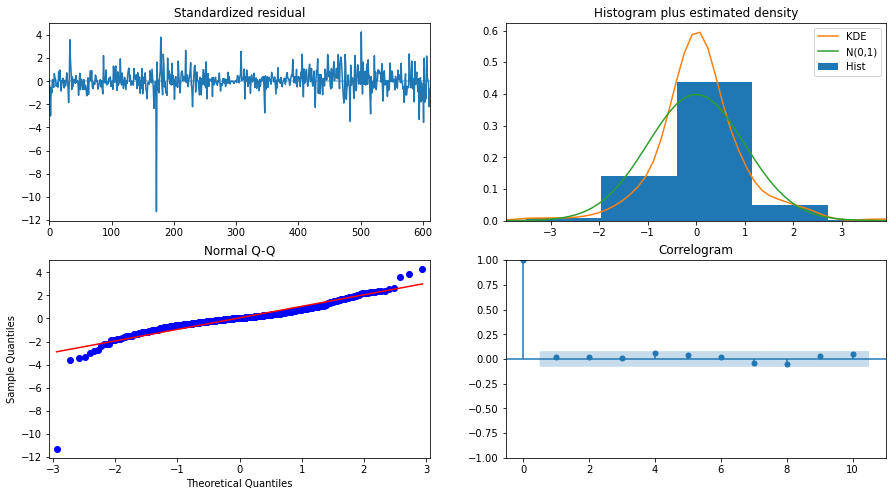

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  612
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1092.685
Method:                       css-mle   S.D. of innovations              0.041
Date:                Fri, 06 Aug 2021   AIC                          -2175.370
Time:                        19:24:48   BIC                          -2153.286
Sample:                             1   HQIC                         -2166.781
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.002      1.268      0.205      -0.001       0.005
ar.L1.D.Close    -0.7708      0.116     -6.628      0.000      -0.999      -0.543
ma.L1.D.Close     0.7123      0.122     

In [15]:
# Forecast
fc, se, conf = fitted.forecast(69, alpha=0.05)  # 95% conf

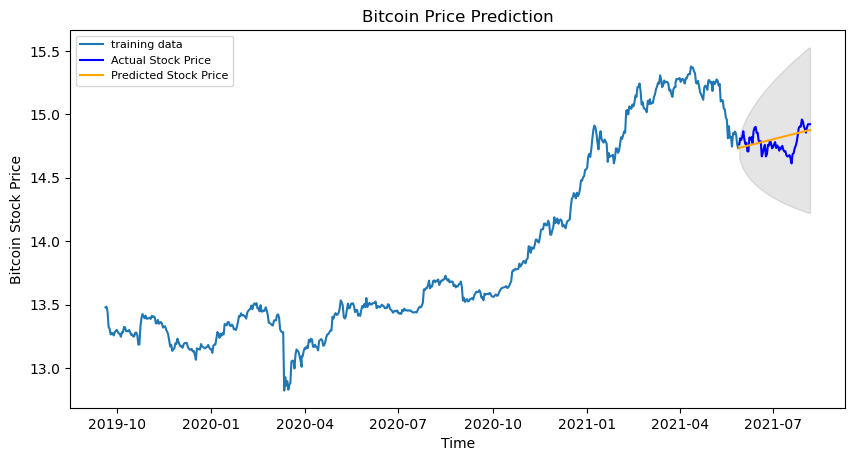

In [16]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
# report performance
fc=fc.reshape(69,1)

mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.007938735578939482
MAE: 0.0746415591220824
RMSE: 0.08909958237241902
MAPE: Close    0.005059
dtype: float64


## Ethereum

In [19]:
#setting the end date to today
end = datetime.today()

#Start date set to 2019-09-17
start = '2019-09-17'

#using yahoo finance to grab data
ETH_df = pdr.DataReader('ETH-INR','yahoo',start,end)

In [20]:
ETH_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-01,198232.812500,186794.953125,190245.593750,194018.343750,1.647405e+12,194018.343750
2021-08-02,195557.671875,181903.187500,193963.312500,185710.765625,1.684429e+12,185710.765625
2021-08-03,205128.484375,182850.500000,186170.531250,202139.406250,1.857620e+12,202139.406250
2021-08-04,210328.500000,188360.062500,202217.296875,209428.296875,2.300549e+12,209428.296875
2021-08-06,210385.031250,202244.765625,210379.312500,205749.296875,2.130127e+12,205749.296875


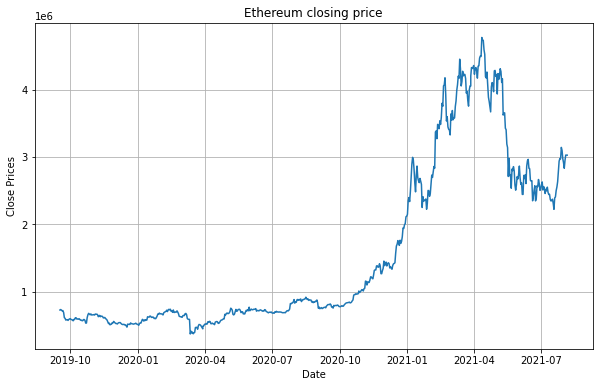

In [21]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(BTC_df['Close'])
plt.title('Ethereum closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

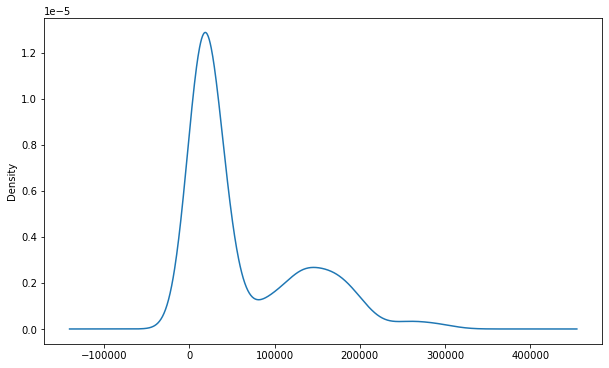

In [22]:
#Distribution of the dataset
df_close = ETH_df['Close']
df_close.plot(kind='kde')

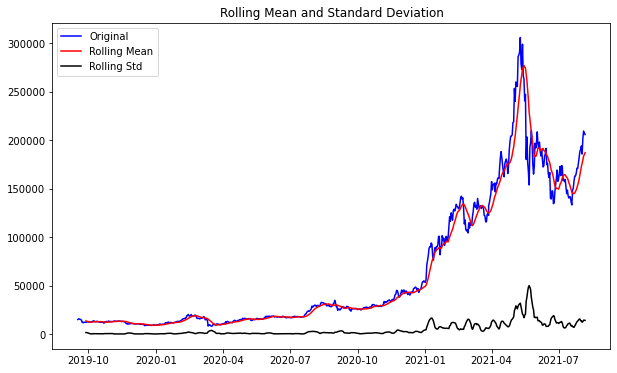

Results of dickey fuller test
Test Statistics                  0.025805
p-value                          0.960615
No. of lags used                16.000000
Number of observations used    668.000000
critical value (1%)             -3.440177
critical value (5%)             -2.865876
critical value (10%)            -2.569079
dtype: float64


In [23]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(ETH_df[['Close']])

<Figure size 720x432 with 0 Axes>

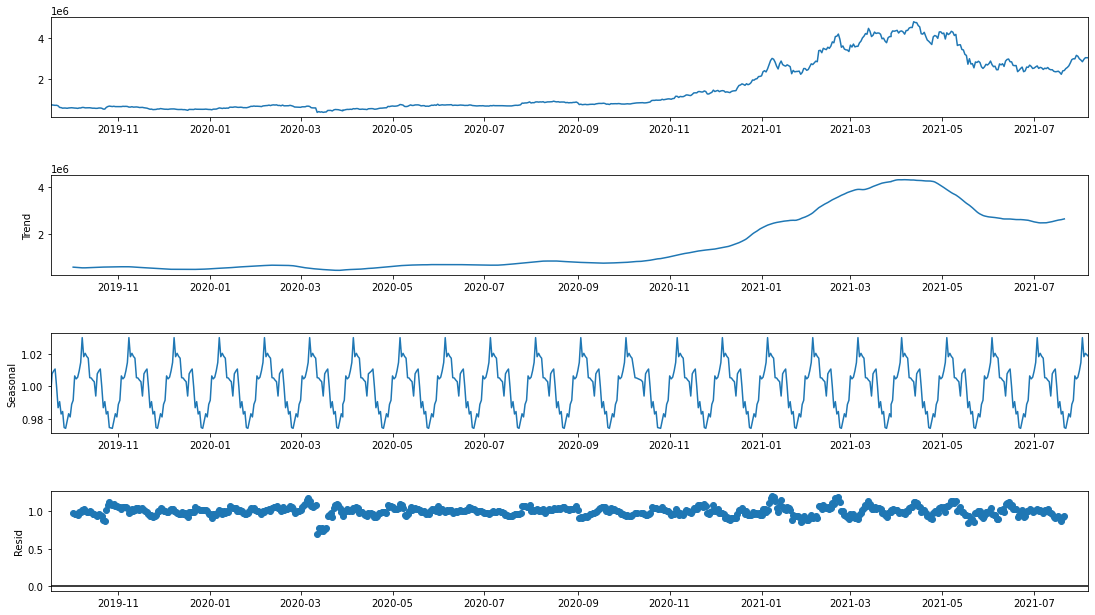

In [24]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
resultETH = seasonal_decompose(ETH_df[['Close']], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


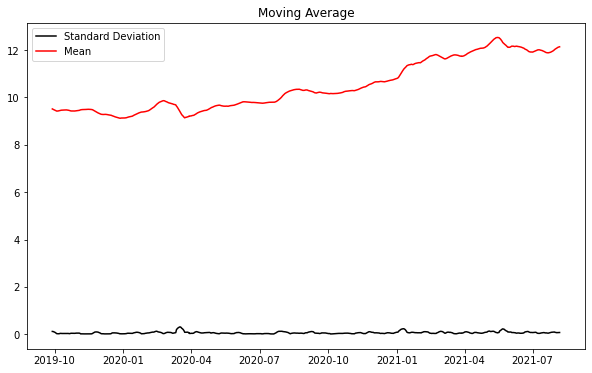

In [25]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
ETH_df_log = np.log(ETH_df[['Close']])
moving_avg = ETH_df_log.rolling(12).mean()
std_dev = ETH_df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

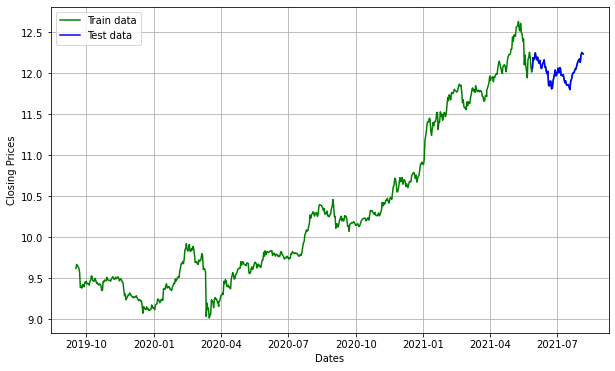

In [26]:
#split data into train and training set
train_data, test_data = ETH_df_log[3:int(len(ETH_df_log)*0.9)], ETH_df_log[int(len(ETH_df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ETH_df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1816.343, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1819.742, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1818.846, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1815.268, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1823.987, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1824.252, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1828.497, Time=1.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1830.400, Time=1.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1831.713, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1830.428, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1821.910, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1828.439, Time=1.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1830.174, Time=0.57 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 8.505 seconds
         

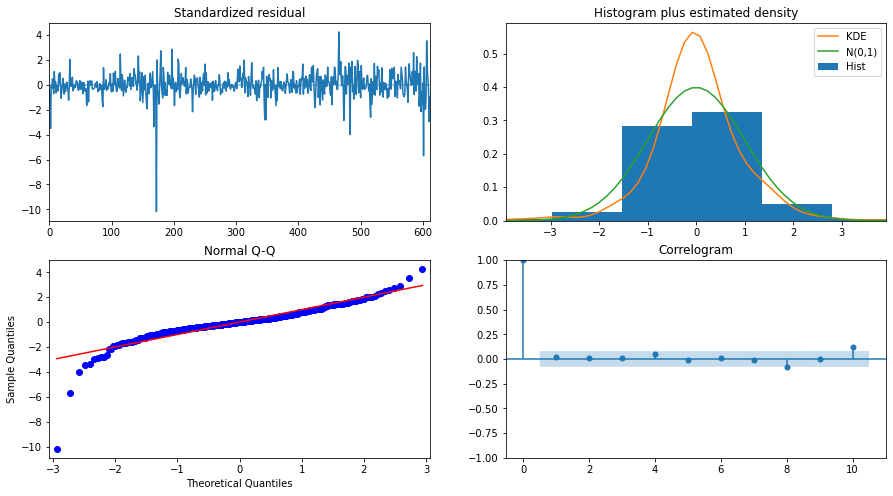

In [27]:
ETH_model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(ETH_model_autoARIMA.summary())
ETH_model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [28]:
#Modeling
# Build Model
model_ETH = ARIMA(train_data, order=(1,1,2))  
fitted = model_ETH.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  612
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 920.214
Method:                       css-mle   S.D. of innovations              0.054
Date:                Fri, 06 Aug 2021   AIC                          -1830.428
Time:                        19:29:26   BIC                          -1808.344
Sample:                             1   HQIC                         -1821.839
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.002      1.820      0.069      -0.000       0.008
ar.L1.D.Close    -0.8408      0.075    -11.151      0.000      -0.989      -0.693
ma.L1.D.Close     0.7752      0.085     

In [31]:
# Forecast
fc, se, conf = fitted.forecast(69, alpha=0.05)  # 95% con

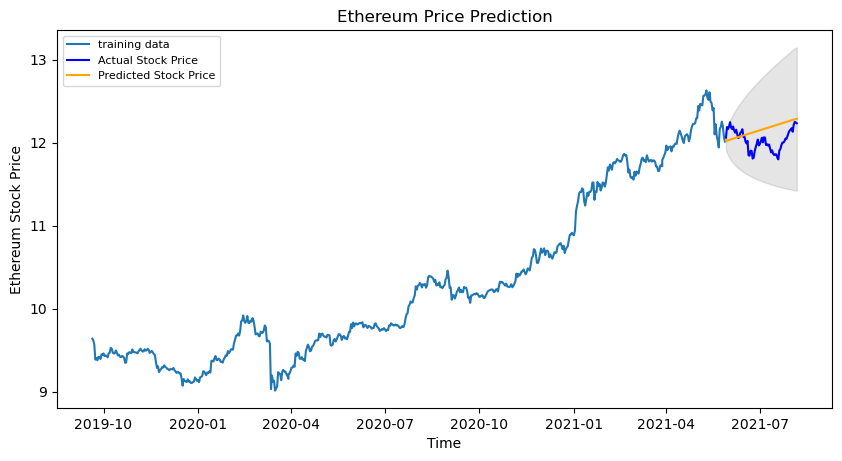

In [32]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Ethereum Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
# report performance
fc=fc.reshape(69,1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.03996359708878929
MAE: 0.17211138696627537
RMSE: 0.19990897200673433
MAPE: Close    0.014377
dtype: float64
